In [ ]:
## pip install xgboost --upgrade

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load data
data = pd.read_csv('augmented_file_50x.csv')

In [3]:
data['label'].value_counts()

label
rice           5000
maize          5000
jute           5000
cotton         5000
coconut        5000
papaya         5000
orange         5000
apple          5000
muskmelon      5000
watermelon     5000
grapes         5000
mango          5000
banana         5000
pomegranate    5000
lentil         5000
blackgram      5000
mungbean       5000
mothbeans      5000
pigeonpeas     5000
kidneybeans    5000
chickpea       5000
coffee         5000
Name: count, dtype: int64

In [4]:
# Split data into features and labels
X = data.drop('label', axis=1)
y = data['label']

# Lists to collect split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Split each label's data separately
labels = y.unique()
for label in labels:
    X_label = X[y == label]
    y_label = y[y == label]
    
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
        X_label, y_label, test_size=0.20, random_state=0)
    
    X_train_list.append(X_train_label)
    X_test_list.append(X_test_label)
    y_train_list.append(y_train_label)
    y_test_list.append(y_test_label)

# Concatenate splits
X_train = pd.concat(X_train_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))



Training set size: 88000
Testing set size: 22000


Cross-validated accuracy scores for each fold: [0.97495455 0.97481818 0.97490909 0.95022727 0.97472727]
Mean CV Accuracy: 0.9699272727272726
Standard Deviation of CV Accuracy: 0.009850309388101604
Random Forest Test accuracy: 0.9486818181818182
Random Forest Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.88      0.99      0.93      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       1.00      0.96      0.98      1000
      coffee       1.00      1.00      1.00      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      1.00      1.00      1000
        jute       1.00      0.17      0.30      1000
 kidneybeans       1.00      1.00      1.00      1000
      lentil       0.91      1.00      0.95      1000
       maize       0.99      1.00      0.99      1000
       mango   

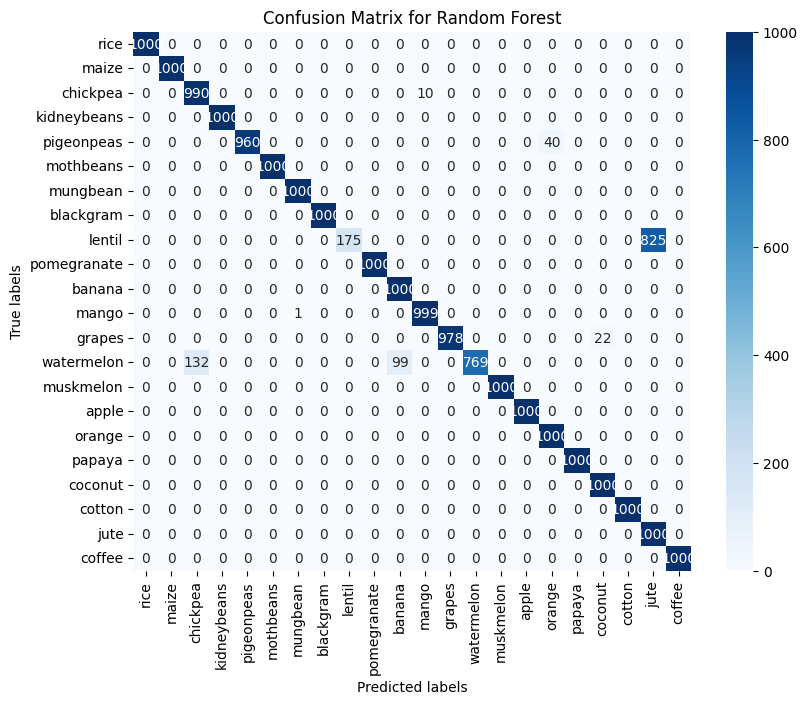

In [6]:
# Random Forest
clf_rf = RandomForestClassifier(n_estimators=90, max_depth=6, max_features=4, random_state=0)
clf_rf.fit(X_train, y_train)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_rf, X, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

y_pred_rf = clf_rf.predict(X_test)
accuracy_score_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Test accuracy:", accuracy_score_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_rf = label_binarize(y_pred_rf, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(9,7))
sns.heatmap(conf_mat_rf, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


# # Compute macro-average ROC curve and ROC area for multi-class task
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred_rf[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# print("Random Forest Macro-average of ROC curve:", roc_auc["macro"])

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve for Random Forest')
# plt.legend(loc="lower right")
# plt.show()



Cross-validated accuracy scores for each fold (KNN): [0.92232955 0.92181818 0.92045455 0.91943182 0.92426136]
Mean CV Accuracy (KNN): 0.9216590909090909
Standard Deviation of CV Accuracy (KNN): 0.0016527744017683047
K-nearest Neighbors Test accuracy: 0.9307272727272727
K-nearest Neighbors Classification Report:
              precision    recall  f1-score   support

       apple       0.81      1.00      0.90      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.84      0.98      0.91      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.96      1.00      0.98      1000
      coffee       1.00      1.00      1.00      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      0.77      0.87      1000
        jute       0.72      1.00      0.84      1000
 kidneybeans       0.88      1.00      0.93      1000
      lentil       0.92      0.93      0.93      1000
       maize       1.00      1.00     

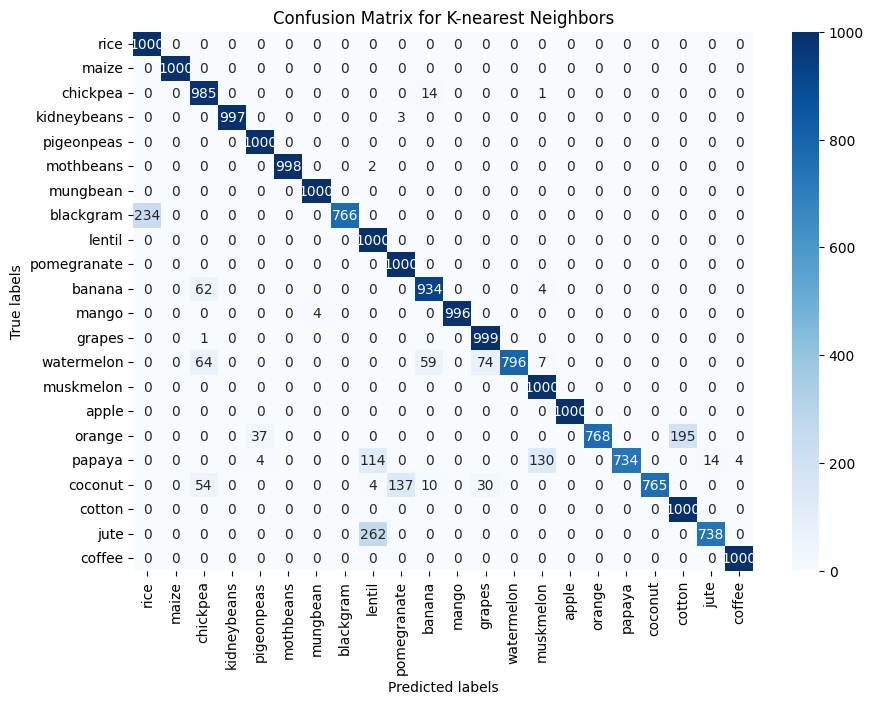

In [7]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the K-nearest neighbors (KNN) classifier with adjusted parameters
clf_knn = KNeighborsClassifier(n_neighbors=5001, weights='distance', algorithm='auto', p=2)

# Fit the KNN model with scaled training data
clf_knn.fit(X_train_scaled, y_train)

# Perform 5-fold cross-validation
cv_scores_knn = cross_val_score(clf_knn, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold (KNN):", cv_scores_knn)
print("Mean CV Accuracy (KNN):", cv_scores_knn.mean())
print("Standard Deviation of CV Accuracy (KNN):", cv_scores_knn.std())

# Predict using the KNN model on the scaled test set
y_pred_knn = clf_knn.predict(X_test_scaled)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)

print("K-nearest Neighbors Test accuracy:", accuracy_score_knn)
print("K-nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_knn = label_binarize(y_pred_knn, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(9,7))
sns.heatmap(conf_mat_knn, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-nearest Neighbors')  # Updated the title here
plt.show()


Cross-validated accuracy scores for each fold: [0.95813636 0.95804545 0.95831818 0.95822727 0.95831818]
Mean CV Accuracy: 0.958209090909091
Standard Deviation of CV Accuracy: 0.0001060173071790149
Naive Bayes Test accuracy: 0.9545454545454546
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.88      0.97      0.92      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       1.00      0.91      0.95      1000
      coffee       1.00      0.98      0.99      1000
      cotton       0.93      1.00      0.97      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.75      1.00      0.86      1000
 kidneybeans       0.89      1.00      0.94      1000
      lentil       0.88      1.00      0.94      1000
       maize       1.00      0.90      0.95      1000
       mango       0.99      1.00      1.00      1000


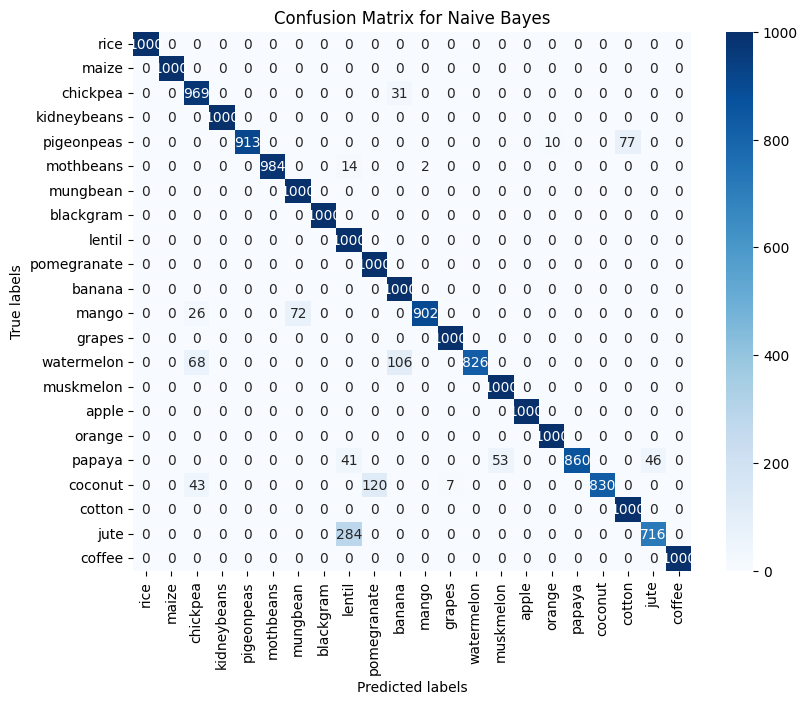

In [8]:
# Set var_smoothing parameter for regularization; you can adjust the value as needed
# Naive Bayes with regularization
var_smoothing_value = 1e-1
clf_nb = GaussianNB(var_smoothing=var_smoothing_value)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_nb, X, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Fit the model with the training data and predict for the test set
clf_nb.fit(X_train, y_train)  # Adjusted the dataset names here
y_pred_nb = clf_nb.predict(X_test)
accuracy_score_nb = accuracy_score(y_test, y_pred_nb)

# Print the Naive Bayes Classification Report
print("Naive Bayes Test accuracy:", accuracy_score_nb)
print(classification_report(y_test, y_pred_nb))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_nb = label_binarize(y_pred_nb, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(9,7))
sns.heatmap(conf_mat_nb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes')  # Updated the title here
plt.show()


# # For the ROC Curve for multi-class
# y_bin_test_nb = label_binarize(y_test, classes=data['label'].unique())
# y_bin_pred_nb = label_binarize(y_pred_nb, classes=data['label'].unique())
# n_classes_nb = y_bin_test_nb.shape[1]

# fpr_nb = dict()
# tpr_nb = dict()
# roc_auc_nb = dict()

# for i in range(n_classes_nb):
#     fpr_nb[i], tpr_nb[i], _ = roc_curve(y_bin_test_nb[:, i], y_bin_pred_nb[:, i])
#     roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])

# all_fpr_nb = np.unique(np.concatenate([fpr_nb[i] for i in range(n_classes_nb)]))
# mean_tpr_nb = np.zeros_like(all_fpr_nb)
# for i in range(n_classes_nb):
#     mean_tpr_nb += np.interp(all_fpr_nb, fpr_nb[i], tpr_nb[i])
# mean_tpr_nb /= n_classes_nb

# fpr_nb["macro"] = all_fpr_nb
# tpr_nb["macro"] = mean_tpr_nb
# roc_auc_nb["macro"] = auc(fpr_nb["macro"], tpr_nb["macro"])

# print("Naive Bayes Macro-average of ROC curve on Test Set:", roc_auc_nb["macro"])

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr_nb["macro"], tpr_nb["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc_nb["macro"]),
#          color='navy', linestyle=':', linewidth=4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve for Naive Bayes')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# # Use pipeline to ensure that the data is scaled before applying SVM
# clf_svm = make_pipeline(
#     StandardScaler(), 
#     SVC(gamma = 0.1, C=0.01, random_state=0) # Updated kernel and gamma
# )

# # Using the pipeline to fit and predict ensures that scaling is applied in each step of CV and prediction.
# clf_svm.fit(X_train_temp, y_train_temp)

# # Perform 5-fold cross-validation
# cv_scores_svm = cross_val_score(clf_svm, X, y, cv=5, scoring='accuracy')

# # Print out the scores for each fold and average accuracy for SVM
# print("Cross-validated accuracy scores for each fold (SVM):", cv_scores_svm)
# print("Mean CV Accuracy (SVM):", cv_scores_svm.mean())
# print("Standard Deviation of CV Accuracy (SVM):", cv_scores_svm.std())

# y_pred_svm = clf_svm.predict(X_test)
# accuracy_score_svm = accuracy_score(y_test, y_pred_svm)

# print("SVM Test accuracy:", accuracy_score_svm)
# print("SVM Classification Report:")
# print(classification_report(y_test, y_pred_svm))

# # Binarize the labels for SVM
# y_bin_test = label_binarize(y_test, classes=data['label'].unique())
# y_bin_pred_svm = label_binarize(y_pred_svm, classes=data['label'].unique())
# n_classes = y_bin_test.shape[1]

# # Compute the confusion matrix
# conf_mat_svm = confusion_matrix(y_test, y_pred_rf)

# # Extract unique class labels
# class_labels = data['label'].unique()

# # Plot using Seaborn
# plt.figure(figsize=(10,7))
# sns.heatmap(conf_mat_svm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix for SVM')
# plt.show()

# # # Compute macro-average ROC curve and ROC area for multi-class task for SVM
# # fpr_svm = dict()
# # tpr_svm = dict()
# # roc_auc_svm = dict()

# # for i in range(n_classes):
# #     fpr_svm[i], tpr_svm[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred_svm[:, i])
# #     roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# # all_fpr_svm = np.unique(np.concatenate([fpr_svm[i] for i in range(n_classes)]))
# # mean_tpr_svm = np.zeros_like(all_fpr_svm)
# # for i in range(n_classes):
# #     mean_tpr_svm += np.interp(all_fpr_svm, fpr_svm[i], tpr_svm[i])
# # mean_tpr_svm /= n_classes

# # fpr_svm["macro"] = all_fpr_svm
# # tpr_svm["macro"] = mean_tpr_svm
# # roc_auc_svm["macro"] = auc(fpr_svm["macro"], tpr_svm["macro"])

# # print("SVM Macro-average of ROC curve:", roc_auc_svm["macro"])

# # # Plot the ROC curve for SVM
# # plt.figure()
# # plt.plot(fpr_svm["macro"], tpr_svm["macro"],
# #          label='macro-average ROC curve (area = {0:0.2f})'
# #                ''.format(roc_auc_svm["macro"]),
# #          color='green', linestyle=':', linewidth=4)
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('Receiver Operating Characteristic Curve for SVM')
# # plt.legend(loc="lower right")
# # plt.show()

Cross-validated accuracy scores for each fold: [0.92040909 0.92031818 0.92104545 0.92077273 0.92009091]
Mean CV Accuracy: 0.9205272727272726
Standard Deviation of CV Accuracy: 0.000339664394404891
Logistic Regression Test accuracy: 0.9176818181818182
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       0.99      1.00      0.99      1000
   blackgram       0.79      0.91      0.85      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.91      1.00      0.95      1000
      coffee       0.99      1.00      0.99      1000
      cotton       0.94      0.97      0.96      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.87      0.73      0.79      1000
 kidneybeans       0.90      0.99      0.94      1000
      lentil       0.88      0.88      0.88      1000
       maize       0.97      0.94      0.96      1000
   

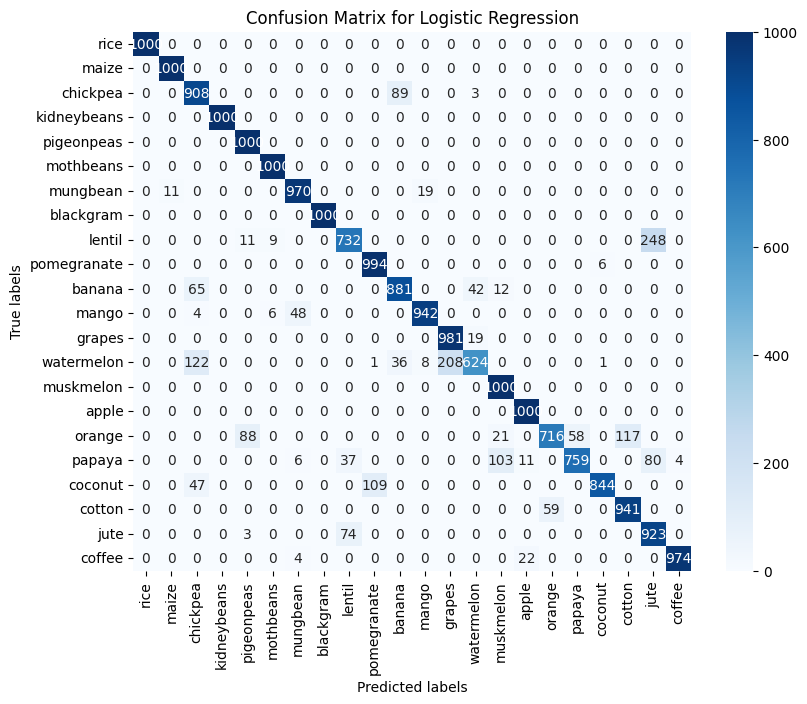

In [9]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Adjusted the dataset name here
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with stronger regularization (smaller C value)
clf_lr = LogisticRegression(C=0.001, max_iter=5000, random_state=0)  
clf_lr.fit(X_train_scaled, y_train)  # Adjusted the dataset names here

# Remember to scale the entire dataset for cross-validation
X_scaled = scaler.transform(X)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_lr, X_scaled, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

y_pred_lr = clf_lr.predict(X_test_scaled)
accuracy_score_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Test accuracy:", accuracy_score_lr)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_lr = label_binarize(y_pred_lr, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(9,7))
sns.heatmap(conf_mat_lr, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')  # Updated the title here
plt.show()


Cross-validated accuracy scores for each fold: [0.96573864 0.97017045 0.96852273 0.96215909 0.95971591]
Mean CV Accuracy: 0.9652613636363636
Standard Deviation of CV Accuracy: 0.0038817423347923367
XGBoost Test accuracy: 0.9643181818181819
XGBoost Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.89      0.99      0.94      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.79      0.99      0.88      1000
      coffee       1.00      1.00      1.00      1000
      cotton       0.99      0.99      0.99      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.83      1.00      0.91      1000
 kidneybeans       1.00      1.00      1.00      1000
      lentil       0.94      1.00      0.97      1000
       maize       0.99      0.99      0.99      1000
       mango       0.97   

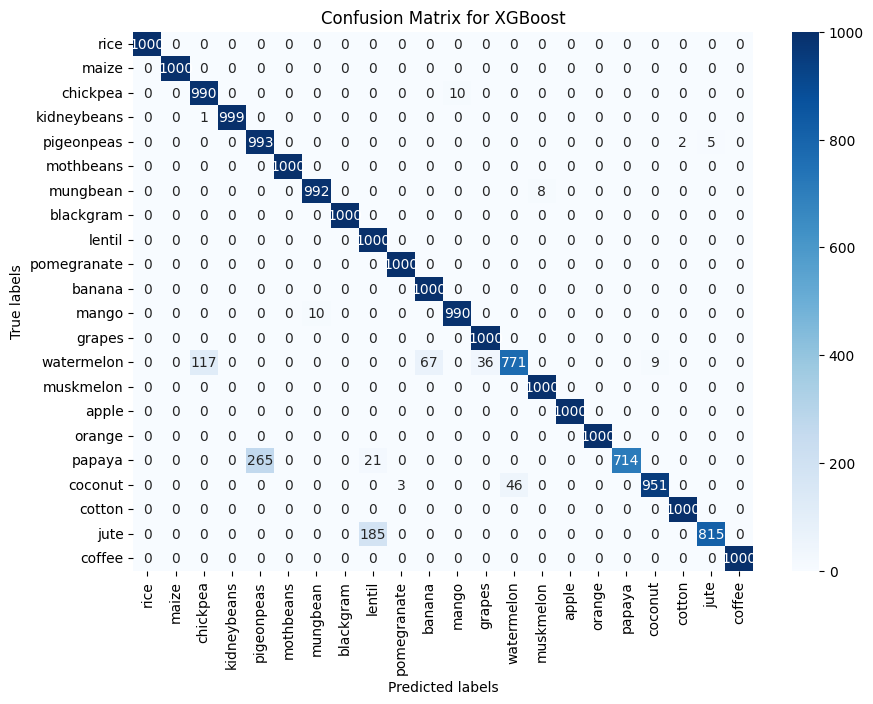

In [10]:
# Convert string labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # Adjusted the dataset name here
y_test_encoded = le.transform(y_test)

# Define the XGBoost classifier with modifications
clf_xgb = xgb.XGBClassifier(
    n_estimators=5,         # Number of boosting rounds.
    max_depth=3,            # Maximum tree depth for base learners.
    min_child_weight=5,     # Minimum sum of instance weight (hessian) needed in a child.
    gamma=0.01,             # Minimum loss reduction required to make a further partition.
    learning_rate=0.03,     # Boosting learning rate (xgb's "eta")
    objective='multi:softmax', # Multiclass classification using the softmax objective
    random_state=0          # Seed for reproducibility
)

# Fit the model
clf_xgb.fit(X_train, y_train_encoded)  # Adjusted the dataset names here

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_xgb, X_train, y_train_encoded, cv=5, scoring='accuracy')  # Adjusted the dataset names here

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Decode the predicted labels to original string format
y_pred_xgb = le.inverse_transform(clf_xgb.predict(X_test))

# Use the decoded predicted labels for calculating accuracy and plotting confusion matrix
accuracy_score_xgb = accuracy_score(y_test, y_pred_xgb)

print("XGBoost Test accuracy:", accuracy_score_xgb)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_xgb = label_binarize(y_pred_xgb, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_xgb = confusion_matrix(y_test, y_pred_xgb)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(9,7))
sns.heatmap(conf_mat_xgb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')  # Updated the title here
plt.show()


In [11]:
# Accuracy Results
print("Random Forest Accuracy:", accuracy_score_rf)
print("KNN:", accuracy_score_knn)
print("Naive Bayes Accuracy:", accuracy_score_nb)
# print("SVM Accuracy:", accuracy_score_svm)
print("Logistic Regression Accuracy (Scaled Data):", accuracy_score_lr)
print("XGBoost Accuracy:", accuracy_score_xgb)


Random Forest Accuracy: 0.9486818181818182
KNN: 0.9307272727272727
Naive Bayes Accuracy: 0.9545454545454546
Logistic Regression Accuracy (Scaled Data): 0.9176818181818182
XGBoost Accuracy: 0.9643181818181819


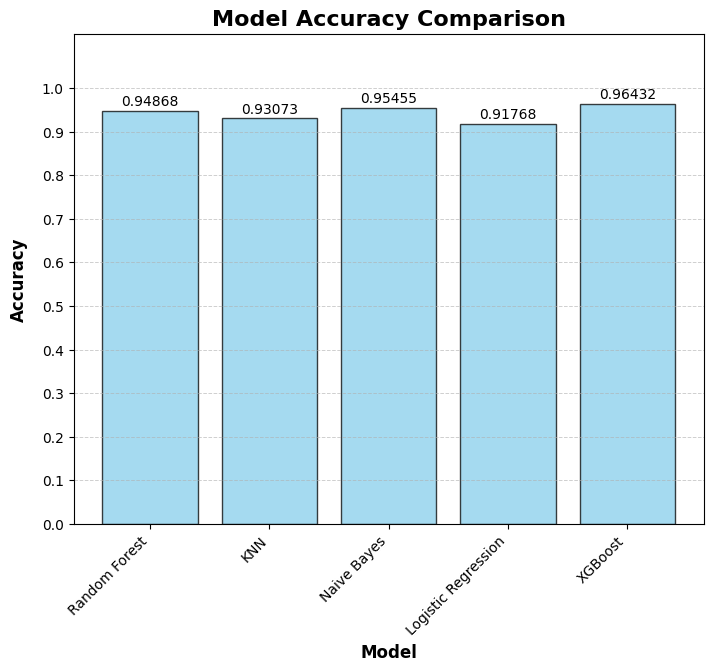

In [12]:
model_names = ['Random Forest', 'KNN', 'Naive Bayes', 'Logistic Regression', 'XGBoost'] # Add 'SVM'
accuracies = [accuracy_score_rf, accuracy_score_knn, accuracy_score_nb, accuracy_score_lr, accuracy_score_xgb] # Add ccuracy_score_svm

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))

# Using consistent colors with a slight alpha transparency and edge color
bars = ax.bar(model_names, accuracies, color='skyblue', alpha=0.75, edgecolor='black')

# Adding data labels with 4 decimal places
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, "{:.5f}".format(yval), ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold', labelpad=10)  # labelpad adds some padding to the ylabel
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.125)  # Added a bit more space at the top for the data labels
ax.set_yticks([i/10 for i in range(11)])
ax.set_yticklabels([i/10 for i in range(11)], fontsize=10)
ax.set_xticks(range(len(model_names)))

# Adjusting font size of the classifier names
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Reduced font size to 10

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)  # Adding horizontal grid lines

# Adjust the position of the axes to create margins inside the chart
ax.set_position([0.5, 0.5, 0.7, 0.7])  # left, bottom, width, height


plt.show()

**Making Predictions**

In [16]:
# Define the original feature names and input data
original_feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
data = np.array([[104, 18, 30, 23.60301571, 60.39647474, 6.779832611, 140.9370415]])
data_df = pd.DataFrame(data, columns=original_feature_names)

# List of classifiers
classifiers = {
    "Random Forest": clf_rf,
    "KNN": clf_knn,
    "Naive Bayes": clf_nb,
    "Logistic Regression": clf_lr,
    "XGBoost": clf_xgb,
}

# Predict using each classifier and print the prediction
for clf_name, clf in classifiers.items():
    proba = clf.predict_proba(data_df.values)
    predicted_index = np.argmax(proba)  # index of max probability
    
    if clf_name == "XGBoost":
        predicted_label = le.inverse_transform([predicted_index])[0]
    else:
        # Assuming your classifiers have classes_ attribute to get label names
        predicted_label = clf.classes_[predicted_index]
    
    confidence = proba[0][predicted_index] * 100  # Fetching the probability of the predicted class
    
    print(f"{clf_name} prediction: {predicted_label} with {confidence:.4f}% confidence")




Random Forest prediction: coffee with 64.9699% confidence
KNN prediction: rice with 64.0789% confidence
Naive Bayes prediction: coffee with 93.9712% confidence
Logistic Regression prediction: rice with 100.0000% confidence
XGBoost prediction: coffee with 12.6570% confidence
